<a href="https://colab.research.google.com/github/AlephEleven/datascience-projects/blob/main/cifar10/Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import datetime

In [ ]:
if('cifar' not in dir(datasets)): #check for cifar
  print("cifar not in datasets")
else:
  data_path = "data/"
  cifar10_train = datasets.CIFAR10(data_path,
                         train=True,
                         download=True,
                             transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))]))
  
  cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
        (0.2470, 0.2435, 0.2616))]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


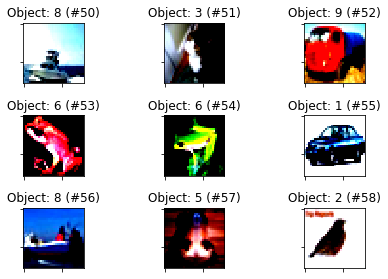

In [ ]:
# Display data
n = 3
offset = 50
figure, axis = plt.subplots(n, n)
figure.tight_layout()
indx = 0 + offset
for i in range(n):
  for j in range(n):
    axis[i, j].imshow(cifar10_train[indx+offset][0].permute(1, 2, 0), interpolation='nearest')
    axis[i, j].set_title(f"Object: {cifar10_train[indx+offset][1]} (#{indx})")
    axis[i, j].set_yticklabels([])
    axis[i, j].set_xticklabels([])
    indx += 1

plt.show()

In [ ]:
#Convolution Model
# [3C x 32 x 32] -> [16C x 32 x 32] -> tanh -> [16C x 16 x 16] -> [8C x 16 x 16] -> tanh -> [8C x 8 x 8] 
# -> flatten -> lin32 -> tanh -> lin10
#input is rgb 32x32 image, output is 10 possible objects.
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 10)
  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
#change runtime type to GPU/TPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
#Train
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device) #send to current device
      labels = labels.to(device=device) #
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=64,shuffle=True)

model = Net().to(device=device) #move model to device
optimizer = optim.Adam(model.parameters(), lr=1e-2) #
loss_fn = nn.CrossEntropyLoss() #
training_loop(
  n_epochs = 200,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

2022-05-28 21:13:07.728153 Epoch 1, Training loss 2.031951287061052
2022-05-28 21:14:50.403442 Epoch 10, Training loss 1.2141327402933175
2022-05-28 21:16:44.025061 Epoch 20, Training loss 1.0453034524265152
2022-05-28 21:18:37.416155 Epoch 30, Training loss 0.9502776570789649
2022-05-28 21:20:28.931518 Epoch 40, Training loss 0.8862814923838886
2022-05-28 21:22:18.222605 Epoch 50, Training loss 0.8387022910215666
2022-05-28 21:24:08.053593 Epoch 60, Training loss 0.8023295085448439
2022-05-28 21:25:57.278493 Epoch 70, Training loss 0.7730007566454465
2022-05-28 21:27:47.384068 Epoch 80, Training loss 0.7468551668288458
2022-05-28 21:29:39.182808 Epoch 90, Training loss 0.725396301473498
2022-05-28 21:31:29.222794 Epoch 100, Training loss 0.7072076064622616
2022-05-28 21:33:18.615147 Epoch 110, Training loss 0.6890173746877924
2022-05-28 21:35:07.034756 Epoch 120, Training loss 0.6742212815815226
2022-05-28 21:36:55.853763 Epoch 130, Training loss 0.6589489258311289
2022-05-28 21:38:45

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "drive/MyDrive/Pytorch/models/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), data_path + 'cifar10.pt')

In [ ]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'cifar10.pt', map_location=device))

<All keys matched successfully>

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=64,shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,shuffle=False)
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device) #send to current device
        labels = labels.to(device=device) #
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    print("Accuracy {}: {:.2f}".format(name , correct / total))
validate(loaded_model, train_loader, val_loader)

Accuracy train: 0.78
Accuracy val: 0.63


In [ ]:
#use loaded model to train this time

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=64,shuffle=True)

optimizer = optim.SGD(loaded_model.parameters(), lr=1e-2) #
loss_fn = nn.CrossEntropyLoss() #
training_loop(
  n_epochs = 30,
  optimizer = optimizer,
  model = loaded_model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

2022-05-28 22:04:13.621189 Epoch 1, Training loss 0.5917228312824693
2022-05-28 22:05:51.087700 Epoch 10, Training loss 0.5843123156777428
2022-05-28 22:07:39.466574 Epoch 20, Training loss 0.5741514812421311
2022-05-28 22:09:28.186251 Epoch 30, Training loss 0.5705928768190887
